In [17]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option("display.max_columns", 200)
RANDOM_SEED = 42

In [18]:
CSV_PATH = "scent-to-scene.csv"  # <- 改成你的路径
df = pd.read_csv(CSV_PATH)

df.shape, df.head(5)


((72, 29),
    participant_id  trial_id mixture_id scene_ground_truth mixture_type  \
 0               1         1        a-I           hospital    canonical   
 1               2         2        a-I           hospital    canonical   
 2               3         3        a-I           hospital    canonical   
 3               4         4        a-I           hospital    canonical   
 4               5         5        a-I           hospital    canonical   
 
    cue_disinfectant  cue_rubber  cue_iodine  cue_butter  cue_vanilla  \
 0                 1           1           1           0            0   
 1                 1           1           1           0            0   
 2                 1           1           1           0            0   
 3                 1           1           1           0            0   
 4                 1           1           1           0            0   
 
    cue_strawberry  cue_grass  cue_wood  cue_lily scene_choice  \
 0               0          0  

In [ ]:
scene_order = ["hospital", "bakery", "garden"]

cue_cols = [
    "cue_disinfectant", "cue_rubber", "cue_iodine",  
    "cue_butter", "cue_vanilla", "cue_strawberry",
    "cue_grass", "cue_wood", "cue_lily",
]

abs_cols = ["img_clean(1-9)", "img_sweet(1-9)", "img_natural(1-9)", "img_chemical(1-9)"]

obj_cols = [
    "img_obj_disinfectant", "img_obj_rubber", "img_obj_iodine",
    "img_obj_butter", "img_obj_vanilla", "img_obj_strawberry",
    "img_obj_grass", "img_obj_wood", "img_obj_lily",
]

required = ["participant_id", "trial_id", "mixture_id", "scene_choice"] + cue_cols + abs_cols + obj_cols
missing = [c for c in required if c not in df.columns]
missing


[]

In [20]:
def yesno_to01(x):
    if pd.isna(x):
        return 0
    s = str(x).strip().lower()
    return 1 if s in ["yes", "y", "1", "true", "t"] else 0

# Cues
X_cue = df[cue_cols].apply(pd.to_numeric, errors="coerce").fillna(0).to_numpy(dtype=float)

# Abstract imagery (z-score)
I_abs_raw = df[abs_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
I_abs = (I_abs_raw - I_abs_raw.mean(axis=0)) / (I_abs_raw.std(axis=0) + 1e-8)

# Concrete imagery (yes/no -> 0/1)
X_obj = df[obj_cols].applymap(yesno_to01).to_numpy(dtype=float)

# Scene labels
y = df["scene_choice"].astype(pd.CategoricalDtype(categories=scene_order)).cat.codes.to_numpy()

if np.any(y < 0):
    bad = df.loc[y < 0, "scene_choice"].unique()
    raise ValueError(f"Unknown scene_choice labels: {bad}. Expected {scene_order}.")

N = len(df)
K = len(scene_order)
D_cue = X_cue.shape[1]
D_abs = I_abs.shape[1]
D_obj = X_obj.shape[1]

(N, K, D_cue, D_abs, D_obj)


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_75748/3299342029.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_obj = df[obj_cols].applymap(yesno_to01).to_numpy(dtype=float)


(72, 3, 9, 4, 9)

In [21]:
print("Unique mixtures:", sorted(df["mixture_id"].unique()))
print("Scene choice counts:\n", df["scene_choice"].value_counts())

# Check cue vectors are 0/1-ish
print("Cue column sums:\n", pd.Series(X_cue.sum(axis=0), index=cue_cols))

# Check abstract imagery basic ranges (raw, before zscore)
print("Abstract imagery raw describe:\n", df[abs_cols].describe())


Unique mixtures: ['a-I', 'a-II', 'a-III', 'b-I', 'b-II', 'b-III', 'c-I', 'c-II', 'c-III']
Scene choice counts:
 scene_choice
hospital    28
bakery      25
garden      19
Name: count, dtype: int64
Cue column sums:
 cue_disinfectant    40.0
cue_rubber           8.0
cue_iodine          32.0
cue_butter          16.0
cue_vanilla         24.0
cue_strawberry      32.0
cue_grass           24.0
cue_wood            16.0
cue_lily            24.0
dtype: float64
Abstract imagery raw describe:
        img_clean(1-9)  img_sweet(1-9)  img_natural(1-9)  img_chemical(1-9)
count       72.000000       72.000000         72.000000          72.000000
mean         3.527778        4.555556          4.416667           4.277778
std          1.920770        2.812892          2.372079           2.941793
min          1.000000        1.000000          1.000000           1.000000
25%          2.000000        2.000000          2.000000           1.000000
50%          3.000000        5.000000          4.500000         

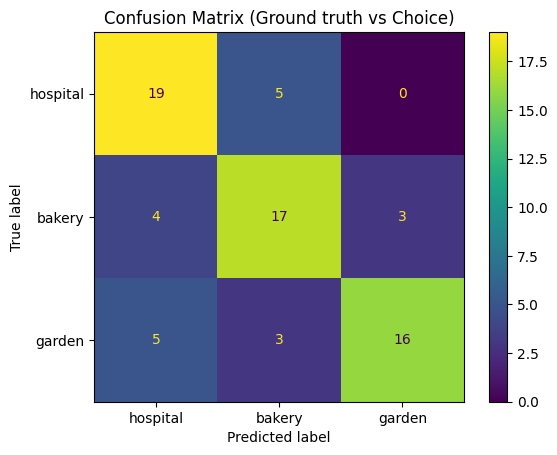

In [22]:
if "scene_ground_truth" in df.columns:
    y_true = df["scene_ground_truth"].astype(pd.CategoricalDtype(categories=scene_order)).cat.codes.to_numpy()
    cm = confusion_matrix(y_true, y, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=scene_order)
    disp.plot()
    plt.title("Confusion Matrix (Ground truth vs Choice)")
    plt.show()
else:
    print("No scene_ground_truth column, skip confusion matrix.")


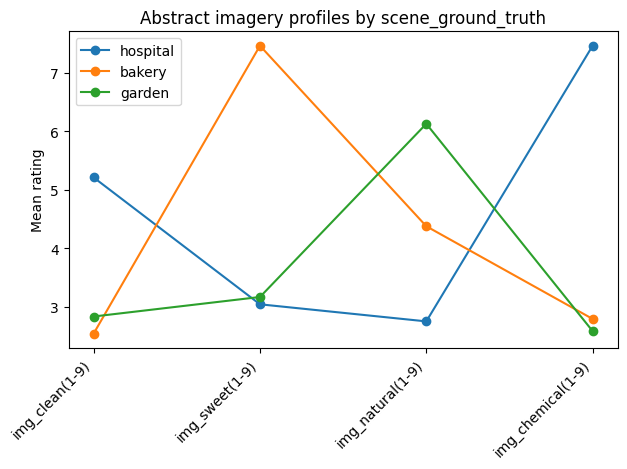

In [23]:
group_col = "scene_ground_truth" if "scene_ground_truth" in df.columns else "scene_choice"
means = df.groupby(group_col)[abs_cols].mean().reindex(scene_order)

plt.figure()
for scene in scene_order:
    if scene in means.index:
        plt.plot(abs_cols, means.loc[scene].values, marker="o", label=scene)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean rating")
plt.title(f"Abstract imagery profiles by {group_col}")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# step 7
with pm.Model() as model_baseline:
    alpha = pm.Normal("alpha", 0, 1.0, shape=K)
    beta  = pm.Normal("beta",  0, 1.0, shape=(D_cue, K))

    logits = alpha + X_cue @ beta  # (N, K)

    y_obs = pm.Categorical("y_obs", logit_p=logits, observed=y)

    idata_base = pm.sample(
        1500, tune=1500, target_accept=0.9,
        chains=4, random_seed=RANDOM_SEED,
        init="adapt_diag"   # ✅ 稳定初始化
    )

az.summary(idata_base, var_names=["alpha", "beta"], round_to=2).head(20)



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.01,0.83,-1.51,1.55,0.01,0.01,6993.21,4049.01,1.0
alpha[1],0.06,0.87,-1.62,1.62,0.01,0.01,6661.43,4383.89,1.0
alpha[2],-0.04,0.85,-1.66,1.58,0.01,0.01,7226.57,4748.67,1.0
"beta[0, 0]",1.02,0.83,-0.56,2.51,0.01,0.01,7180.05,4656.62,1.0
"beta[0, 1]",-0.23,0.81,-1.70,1.33,0.01,0.01,7556.11,4177.18,1.0
"beta[0, 2]",-0.80,0.84,-2.32,0.75,0.01,0.01,7521.79,5060.14,1.0
"beta[1, 0]",0.63,0.87,-1.03,2.20,0.01,0.01,8028.25,4856.40,1.0
"beta[1, 1]",-0.34,0.92,-2.09,1.36,0.01,0.01,7348.53,4570.03,1.0
"beta[1, 2]",-0.27,0.92,-2.05,1.41,0.01,0.01,7122.89,4537.84,1.0
"beta[2, 0]",0.87,0.82,-0.72,2.36,0.01,0.01,6917.94,3905.11,1.0


In [25]:
# step 8
with pm.Model() as model_enc_abs:
    a = pm.Normal("a", 0, 1.0, shape=D_abs)
    W = pm.Normal("W", 0, 1.0, shape=(D_cue, D_abs))
    sigma = pm.Exponential("sigma", 1.0, shape=D_abs)

    mu = a + X_cue @ W
    I_obs = pm.Normal("I_obs", mu=mu, sigma=sigma, observed=I_abs)

    idata_enc = pm.sample(
        1500, tune=1500, target_accept=0.9,
        chains=4, random_seed=RANDOM_SEED
    )

az.summary(idata_enc, var_names=["a", "W", "sigma"], round_to=2).head(20)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, W, sigma]


/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 59 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.24,0.72,-1.55,1.13,0.01,0.01,6072.66,3881.42,1.0
a[1],-0.15,0.71,-1.46,1.23,0.01,0.01,4764.87,4254.70,1.0
a[2],0.09,0.71,-1.16,1.48,0.01,0.01,4730.25,3319.61,1.0
a[3],-0.06,0.71,-1.37,1.29,0.01,0.01,4917.91,3796.53,1.0
"W[0, 0]",1.46,0.41,0.68,2.20,0.01,0.00,5130.52,4875.66,1.0
"W[0, 1]",0.35,0.35,-0.30,1.01,0.01,0.00,3556.09,3790.30,1.0
"W[0, 2]",-1.18,0.35,-1.85,-0.53,0.01,0.00,3035.27,3168.87,1.0
"W[0, 3]",1.08,0.35,0.44,1.76,0.01,0.00,3593.27,3877.24,1.0
"W[1, 0]",-1.33,0.39,-2.02,-0.59,0.01,0.00,4780.97,4663.29,1.0
"W[1, 1]",-0.70,0.34,-1.34,-0.07,0.01,0.00,3437.73,3384.61,1.0


In [26]:
# step 9
with pm.Model() as model_dec_abs:
    alpha = pm.Normal("alpha", 0, 1.0, shape=K)
    gamma = pm.Normal("gamma", 0, 1.0, shape=(D_abs, K))

    logits = alpha + I_abs @ gamma
    logits = logits - logits.mean(axis=1, keepdims=True)

    y_obs = pm.Categorical("y_obs", logit_p=logits, observed=y)

    idata_dec_abs = pm.sample(
        1500, tune=1500, target_accept=0.9,
        chains=4, random_seed=RANDOM_SEED,
        init="adapt_diag"
    )


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, gamma]


/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 6 seconds.


In [27]:
# step 10
# Combine abstract imagery + concrete imagery
X_I_full = np.concatenate([I_abs, X_obj], axis=1)
D_I_full = X_I_full.shape[1]

with pm.Model() as model_dec_full:
    alpha = pm.Normal("alpha", 0, 1.0, shape=K)
    theta = pm.Normal("theta", 0, 1.0, shape=(D_I_full, K))

    logits = alpha + X_I_full @ theta
    logits = logits - logits.mean(axis=1, keepdims=True)

    y_obs = pm.Categorical("y_obs", logit_p=logits, observed=y)

    idata_dec_full = pm.sample(
        1500, tune=1500, target_accept=0.9,
        chains=4, random_seed=RANDOM_SEED,
        init="adapt_diag"
    )

az.summary(idata_dec_full, var_names=["alpha", "theta"], round_to=2).head(20)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, theta]


/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.22,0.86,-1.87,1.36,0.01,0.01,7034.12,4721.06,1.0
alpha[1],0.17,0.86,-1.44,1.75,0.01,0.01,6436.56,3736.69,1.0
alpha[2],0.04,0.87,-1.62,1.64,0.01,0.01,7217.39,4170.42,1.0
"theta[0, 0]",0.65,0.73,-0.66,2.04,0.01,0.01,6669.32,5036.60,1.0
"theta[0, 1]",-0.30,0.76,-1.64,1.21,0.01,0.01,7055.79,5076.19,1.0
"theta[0, 2]",-0.36,0.79,-1.75,1.19,0.01,0.01,7267.13,4344.25,1.0
"theta[1, 0]",-0.72,0.82,-2.20,0.82,0.01,0.01,7067.65,4584.45,1.0
"theta[1, 1]",1.75,0.82,0.19,3.24,0.01,0.01,7299.26,4564.71,1.0
"theta[1, 2]",-0.98,0.82,-2.58,0.52,0.01,0.01,7408.90,4555.74,1.0
"theta[2, 0]",-0.42,0.84,-1.95,1.14,0.01,0.01,7427.08,4871.82,1.0


In [29]:
import pymc as pm
import arviz as az

def ensure_loglik(idata, model, y_name="y_obs"):
    """
    Ensure idata has log_likelihood. If missing, compute and attach it.
    """
    has_ll = hasattr(idata, "log_likelihood") and (y_name in idata.log_likelihood.data_vars)
    if has_ll:
        return idata

    # compute and attach log_likelihood
    with model:
        idata_ll = pm.compute_log_likelihood(idata, var_names=[y_name])
    return idata_ll


# ---- 1) ensure log_likelihood exists ----
idata_base = ensure_loglik(idata_base, model_baseline, y_name="y_obs")
idata_dec_abs = ensure_loglik(idata_dec_abs, model_dec_abs, y_name="y_obs")
idata_dec_full = ensure_loglik(idata_dec_full, model_dec_full, y_name="y_obs")


# ---- 2) now run LOO ----
loo_base = az.loo(idata_base, var_name="y_obs")
loo_abs  = az.loo(idata_dec_abs, var_name="y_obs")
loo_full = az.loo(idata_dec_full, var_name="y_obs")

print("LOO baseline:\n", loo_base)
print("\nLOO imagery (abs):\n", loo_abs)
print("\nLOO imagery (abs+obj):\n", loo_full)

cmp = az.compare(
    {"baseline": idata_base, "imagery_abs": idata_dec_abs, "imagery_abs_obj": idata_dec_full},
    ic="loo",
    method="BB-pseudo-BMA"
)
cmp


/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/jianingyu/Downloads/scent-2-scene/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

LOO baseline:
 Computed from 6000 posterior samples and 72 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -38.13     4.42
p_loo        6.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       72  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


LOO imagery (abs):
 Computed from 6000 posterior samples and 72 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -21.22     3.05
p_loo        3.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       72  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


LOO imagery (abs+obj):
 Computed from 6000 posterior samples and 72 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -16.53     2.44
p_loo        3.76        -
------

Pareto k diagnostic values:
                         Count   Pc

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
imagery_abs_obj,0,-16.525279,3.755500,0.000000,9.795950e-01,2.426998,0.000000,False,log
imagery_abs,1,-21.217101,3.172281,4.691822,2.040499e-02,3.030473,1.498463,False,log
baseline,2,-38.131537,6.016262,21.606258,1.260253e-08,4.369807,2.754546,False,log


In [35]:
# ---- Abstract imagery -> scene weights (gamma) ----
gamma_da = idata_dec_abs.posterior["gamma"]  # dims: (chain, draw, 4, 3)

# 合并 chain+draw -> sample
gamma_flat = gamma_da.stack(sample=("chain", "draw"))  # dims: (gamma_dim_0, gamma_dim_1, sample)

# 转成 numpy 并对 sample 维取平均
gamma_mean = gamma_flat.mean(dim="sample").values      # shape: (4, 3)

gamma_table = pd.DataFrame(gamma_mean, index=abs_cols, columns=scene_order)
gamma_table


,hospital,bakery,garden
img_clean(1-9),0.511924,0.023687,-0.532449
img_sweet(1-9),-0.786739,1.946984,-1.128208
img_natural(1-9),-0.530430,-0.649061,1.178433
img_chemical(1-9),1.774636,-0.942276,-0.800284


In [36]:
for scene in scene_order:
    print(f"\nTop abstract imagery predictors for {scene}:")
    print(gamma_table[scene].sort_values(ascending=False).to_string())



Top abstract imagery predictors for hospital:
img_chemical(1-9)    1.774636
img_clean(1-9)       0.511924
img_natural(1-9)    -0.530430
img_sweet(1-9)      -0.786739

Top abstract imagery predictors for bakery:
img_sweet(1-9)       1.946984
img_clean(1-9)       0.023687
img_natural(1-9)    -0.649061
img_chemical(1-9)   -0.942276

Top abstract imagery predictors for garden:
img_natural(1-9)     1.178433
img_clean(1-9)      -0.532449
img_chemical(1-9)   -0.800284
img_sweet(1-9)      -1.128208


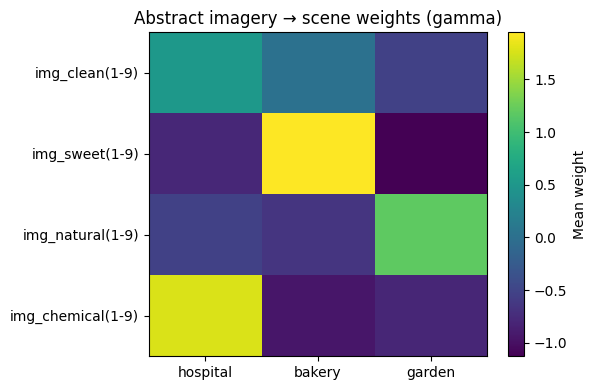

In [37]:
plt.figure(figsize=(6,4))
plt.imshow(gamma_table.values, aspect="auto")
plt.colorbar(label="Mean weight")
plt.xticks(range(len(scene_order)), scene_order)
plt.yticks(range(len(abs_cols)), abs_cols)
plt.title("Abstract imagery → scene weights (gamma)")
plt.tight_layout()
plt.show()


In [38]:
# ---- Abstract + concrete -> scene weights (theta) ----
feature_names_full = abs_cols + obj_cols

theta_da = idata_dec_full.posterior["theta"]  # expected dims: (chain, draw, D_full, 3)
theta_flat = theta_da.stack(sample=("chain", "draw"))

theta_mean = theta_flat.mean(dim="sample").values  # shape: (D_full, 3)

theta_table = pd.DataFrame(theta_mean, index=feature_names_full, columns=scene_order)

# 只看 concrete imagery 部分（更好解释）
theta_obj = theta_table.loc[obj_cols]
theta_obj


,hospital,bakery,garden
img_obj_disinfectant,0.530822,-0.732379,0.179284
img_obj_rubber,0.172166,-0.074418,-0.123829
img_obj_iodine,1.137142,-0.500028,-0.626052
img_obj_butter,-0.568207,0.808143,-0.279737
img_obj_vanilla,-0.585714,0.242149,0.337033
img_obj_strawberry,0.051298,0.278176,-0.308932
img_obj_grass,-0.832724,0.358071,0.467342
img_obj_wood,0.318613,-0.083616,-0.266479
img_obj_lily,-0.164039,-0.315296,0.448815


In [39]:
gamma_table.to_csv("results_gamma_abstract_to_scene.csv", index=True)
theta_obj.to_csv("results_theta_concrete_to_scene.csv", index=True)

print("Saved:")
print(" - results_gamma_abstract_to_scene.csv")
print(" - results_theta_concrete_to_scene.csv")


Saved:
 - results_gamma_abstract_to_scene.csv
 - results_theta_concrete_to_scene.csv
